# Intro to Data Analysis Project
#### William McKee
#### June 2017

In this investigation, we will compare Major League All-Star players and Triple Crown winners to the average player.  How well must a player perform in order to make the All-Star team?  How much better does a player need to perform to win the most prestigious Triple Crown.

Major League Baseball marks the mid-way point of each season by having an All-Star game between the National League and the American League.  The best players in each league are selected by fans, players, managers.  A commission and the All-Star managers select replacements for injured players.  The first All-Star game was played in 1933.  There was only 18 players per league in the first All-Star game; that number has grown steadily to 34 players per league today.

The Triple Crown is awarded to a player who leads in **_batting average_**, **_home runs_**, and **_"runs batted in"_** during a full regular season.  The player's statistics are compared against all other players for either the National or American Leagues.  The player must lead in all three categories; as a result, there are no winners in most seasons.  The most recent winner was Miguel Cabrera, who received the award in 2012 for the American League.

There is a similar award for pitchers called the Pitching Triple Crown.  This is given to a player who has the best **_Earned Run Average_**, **_most wins_**, and **_most strikeouts_** in the same season for either the National or American Leagues.  The player must have the best statistics in all three.  The most recent awards were given in 2011, to Clayton Kershaw in the National League, and to Justin Verlander in the American League.

We will compare the players in the Triple Crown and Pitching Triple Crown metrics.  The analysis will cover the time period from the first All-Star game (1933) through last season (2016).  We will explore the following questions:

(1) How well does a typical player perform in the Triple Crown metrics among batters and pitchers?

(2) How much better must a player perform in these metrics to make the All-Star team?

(3) How much better must a player perform to win the Triple Crown or Pitching Triple Crown?

## Initial Data Gathering

The investigation begins by gathering data about all Major League Baseball players from the Batting and Pitching tables.

In [20]:
# Initial library declarations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Get the all-time batters and pitchers data
alltime_batters = pd.read_csv('Batting.csv')
alltime_pitchers = pd.read_csv('Pitching.csv')

## Data Normalization

Each row in both the Batting and Pitching CSV files contain metrics for **_one player for one team for one season_**.  This seems reasonable at first glance but baseball has a trade deadline every year.  Teams take advantage of that trade deadline in order to acquire players that will help them compete for post season spots.  The data must be adjusted so that a player's full season is included in one row when he played for multiple teams in one season.

There is also some information that must be computed for every row, including batting average and plate appearances.

In [21]:
# === ACCOUNT FOR "STINTS" ===
# Combine rows where players played on multiple teams in a season (reset_index so we can keep grouping columns)
alltime_batters_seasonal = alltime_batters.groupby(['yearID','playerID']).sum().reset_index()
alltime_pitchers_seasonal = alltime_pitchers.groupby(['yearID','playerID']).sum().reset_index()

# === ADD AND CORRECT BATTERS' DATA ===
# Note: Sacrifice Flies were not tracked until 1954 so this calculation substitues zero for earlier seasons
# Add Plate Appearances since each batter will need a minimum number of plate appearances to be part of the study
# Plate Appearance = At bats(AB) + Base on Balls(BB) + Hit by Pitch(HBP) + Sacrifice Hits(SH) + Sacrifice Fly(SF)
alltime_batters_seasonal['PA'] = \
    alltime_batters_seasonal['AB'] + alltime_batters_seasonal['BB'] + alltime_batters_seasonal['HBP'] + \
    alltime_batters_seasonal['SH'] + alltime_batters_seasonal['SF'].fillna(0)

# Add Batting Average to each row for easy access
# Batting Average = Hits(H) / At-Bats(AB)
alltime_batters_seasonal['AVG'] = alltime_batters_seasonal['H'] / alltime_batters_seasonal['AB']

# === ADD AND CORRECT PITCHERS' DATA ===
# Recompute the Earned Run Average (ERA) since the "groupby().sum()" calls summed up the stints' ERAs.
# Earned Run Average = (Earned Runs(ER) / Outs Pitched(IPOuts)) * 27 (27 outs in a full game)
alltime_pitchers_seasonal['ERA'] = \
    (alltime_pitchers_seasonal['ER'] / alltime_pitchers_seasonal['IPouts']) * 27.0

## Narrow the Data Set for this Investigation

We have Batters and Pitchers data containing rows of each player's performance for one full season.

We are comparing All Stars to average players so we must limit our data set to seasons with an All-Star game.  The first All-Star game was played in 1933 so the data set will include only 1933 through 2016 seasons.

In addition, the data set will be limited to batters who made at least one plate appearance per game and pitchers who pitched in at least one out of every ten games on average.  These thresholds reduce the impact of players who rarely saw action or missed many games due to injury.  For example, many American League pitchers never batted during their careers due to the Designated Hitter rule and lack of regular season interleague play before the 1997 season.

In [22]:
import operator

# Constants
FIRST_ALL_STAR_YEAR = 1933
MIN_BATTER_PA_THRESHOLD = 162
MIN_PITCHING_GAMES_THRESHOLD = 16

# Function to return data frame meeting certain condition
def get_data_subset(data_frame, column_name, op, value):
    '''
    Example: get_data_subset(df, 'col1', operator.lt, 10)
    Returns data frame where df contains 'col1' and the value is less than 10
    '''
    data_frame_groups = \
        data_frame.groupby(op(data_frame[column_name], value))
    return data_frame_groups.get_group(1) # Group in condition only

# Get the subset since the first All-Star season
allstar_era_batters = get_data_subset(alltime_batters_seasonal, 'yearID', operator.ge, FIRST_ALL_STAR_YEAR)
allstar_era_pitchers = get_data_subset(alltime_pitchers_seasonal, 'yearID', operator.ge, FIRST_ALL_STAR_YEAR)

# Limit the investigation to players meeting the minimum threshold; this is the "full" set
full_batters = get_data_subset(allstar_era_batters, 'PA', operator.ge, MIN_BATTER_PA_THRESHOLD)
full_pitchers = get_data_subset(allstar_era_pitchers, 'G', operator.ge, MIN_PITCHING_GAMES_THRESHOLD)

## Typical Batter Statistics

Let's take a look at a typical Major League Baseball batter as measured by the Triple Crown criteria of batting average (AVG), home runs (HR), and runs batted in (RBI).

In [23]:
# Standarize single column
def standarize_column(df_column):
    '''
    Standarize one column of a data frame
    '''
    return (df_column - df_column.mean()) / df_column.std(ddof=0)


# Correlation
def correlate_columns(df_column_x, df_column_y):
    '''
    Return the correlation between two columns from a data frame
    The return value will be from -1.0 to 1.0
    '''
    std_x = standarize_column(df_column_x)
    std_y = standarize_column(df_column_y)
    return (std_x * std_y).mean()


# Print data description for a single data frame and single column
def describe_data(data_frame, column_name, format_string):
    '''
    Prints data description one column of a data frame
    '''
    print("Mean: ", format_string.format(data_frame.mean()[column_name]))
    print("Std:  ", format_string.format(data_frame.std()[column_name]))
    print("Min:  ", format_string.format(data_frame.min()[column_name]))
    print("Max:  ", format_string.format(data_frame.max()[column_name]))
    print("\n")


# === Check out Triple Crown Statistics for Batters ===
print("Total Number Of Batters: ", len(full_batters))
print("\n")

print("Typical Batting Average (per batter per season):\n")
describe_data(full_batters, 'AVG', "{:1.3f}")

print("Typical Home Runs (per batter per season):\n")
describe_data(full_batters, 'HR', "{:2.1f}")

print("Typical Runs-Batted-In (per batter per season)\n")
describe_data(full_batters, 'RBI', "{:3.1f}")

Total Number Of Batters:  23404


Typical Batting Average (per batter per season):

Mean:  0.264
Std:   0.033
Min:   0.131
Max:   0.406


Typical Home Runs (per batter per season):

Mean:  10.4
Std:   9.5
Min:   0.0
Max:   73.0


Typical Runs-Batted-In (per batter per season)

Mean:  49.3
Std:   27.8
Min:   2.0
Max:   183.0




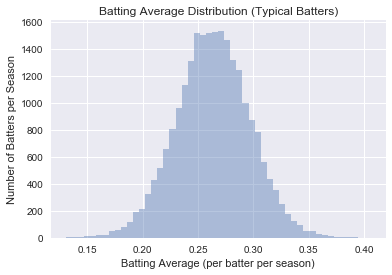

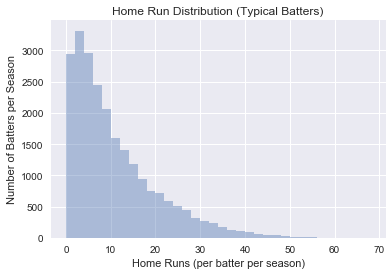

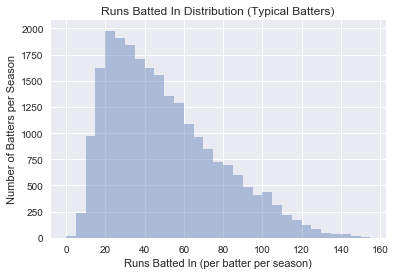

In [24]:
%matplotlib inline

# === Batter Single Dimensional Plots ===
# Batting average
sns.distplot(full_batters['AVG'], kde=False)
plt.title("Batting Average Distribution (Typical Batters)")
plt.xlabel("Batting Average (per batter per season)")
plt.ylabel("Number of Batters per Season")
plt.show()

# Home Runs
hr_bins = np.arange(0,70,2)
sns.distplot(full_batters['HR'], kde=False, bins=hr_bins)
plt.title("Home Run Distribution (Typical Batters)")
plt.xlabel("Home Runs (per batter per season)")
plt.ylabel("Number of Batters per Season")
plt.show()

# Runs Batted In
rbi_bins = np.arange(0,160,5)
sns.distplot(full_batters['RBI'], kde=False, bins=rbi_bins)
plt.title("Runs Batted In Distribution (Typical Batters)")
plt.xlabel("Runs Batted In (per batter per season)")
plt.ylabel("Number of Batters per Season")
plt.show()

Batters Correlation AVG/HR:  0.32


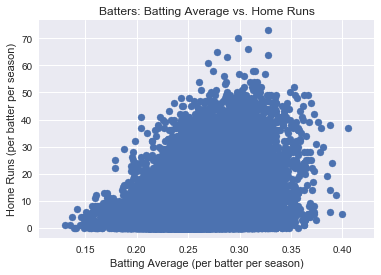



Batters Correlation AVG/RBI:  0.51


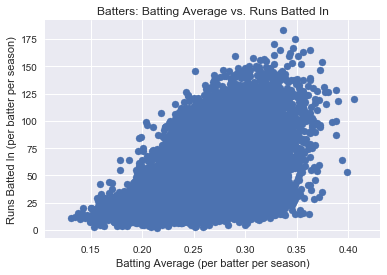



Batters Correlation HR/RBI:  0.85


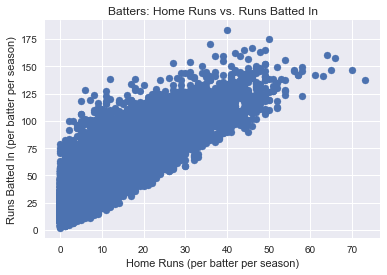

In [25]:
%matplotlib inline

# === Batter Two Dimensional Plots ===
# Batting Average vs. Home Runs
avg_hr_corr = correlate_columns(full_batters['AVG'], full_batters['HR'])
print ("Batters Correlation AVG/HR: ", "{:1.2f}".format(avg_hr_corr))

plt.scatter(full_batters['AVG'], full_batters['HR'])
plt.title("Batters: Batting Average vs. Home Runs")
plt.xlabel("Batting Average (per batter per season)")
plt.ylabel("Home Runs (per batter per season)")
plt.show()
print("\n")

# Batting Average vs. Runs Batted In
avg_rbi_corr = correlate_columns(full_batters['AVG'], full_batters['RBI'])
print ("Batters Correlation AVG/RBI: ", "{:1.2f}".format(avg_rbi_corr))

plt.scatter(full_batters['AVG'], full_batters['RBI'])
plt.title("Batters: Batting Average vs. Runs Batted In")
plt.xlabel("Batting Average (per batter per season)")
plt.ylabel("Runs Batted In (per batter per season)")
plt.show()
print("\n")

# Home Runs vs. Runs Batted In
hr_rbi_corr = correlate_columns(full_batters['HR'], full_batters['RBI'])
print ("Batters Correlation HR/RBI: ", "{:1.2f}".format(hr_rbi_corr))

plt.scatter(full_batters['HR'], full_batters['RBI'])
plt.title("Batters: Home Runs vs. Runs Batted In")
plt.xlabel("Home Runs (per batter per season)")
plt.ylabel("Runs Batted In (per batter per season)")
plt.show()

## Tentative Conculsions about Batter Statistics

Batting Average has a normal distribution among typical Major League Batters while Home Runs and Runs Batted In are positively skewed.

A higher batting average is somewhat positively correlated with the number of Home Runs and Runs Batted In.  The expectation is that a player who gets more hits increases the number of chances of hitting home runs.  However, only a power hitter can expect to see a larger increases in home runs as his batting average goes up.  "Singles hitters" will not see much of a home run increase for a higher batting average.  Pete Rose, for example, has the career Major League record with 4256 hits with a .303 batting average but he hit only 160 Home Runs in his career.

The AVG/RBI correlation is higher then AVG/HR since a batter needs only a base hit to drive in runs when runners are on base.  A home run is not necessary.  Pete Rose had 1314 RBIs despite hitting mostly singles in his career.

The largest positive correlation is HR/RBI.  A home run guarantees at least one RBI since the batter drives himself in along with any runners on base.  A player with ten home runs in a season will have at least ten RBIs.

A higher batting average is correlated with an increase in home runs and runs batted in.  However, different hitter types and the number of runners on base vary greatly, so one cannot imply causation.

## Typical Pitcher Statistics

Let's take a look at a typical Major League Baseball pitcher as measured by the Pitching Triple Crown criteria of earned run average (ERA), wins (W), and strikeouts (SO).

In [26]:
# === Check out Triple Crown Statistics for Pitchers ===
print("Total Number Of Pitchers: ", len(full_pitchers))
print("\n")

print("Typical Earned Run Average (ERA) (per pitcher per season):\n")
describe_data(full_pitchers, 'ERA', "{:1.2f}")

print("Typical Wins (per pitcher per season):\n")
describe_data(full_pitchers, 'W', "{:2.1f}")

print("Typical Strikeouts (per pitcher per season):\n")
describe_data(full_pitchers, 'SO', "{:3.1f}")

Total Number Of Pitchers:  21847


Typical Earned Run Average (ERA) (per pitcher per season):

Mean:  4.06
Std:   1.26
Min:   0.38
Max:   13.89


Typical Wins (per pitcher per season):

Mean:  6.6
Std:   5.2
Min:   0.0
Max:   31.0


Typical Strikeouts (per pitcher per season):

Mean:  72.4
Std:   48.7
Min:   2.0
Max:   383.0




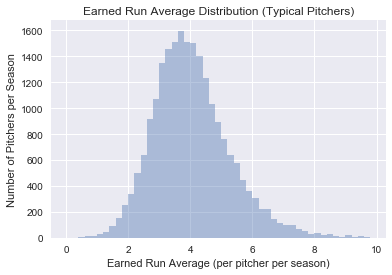

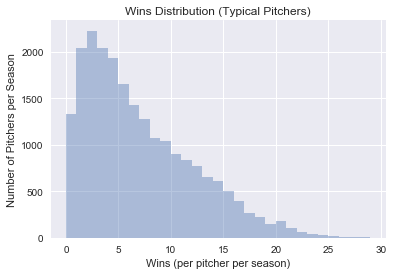

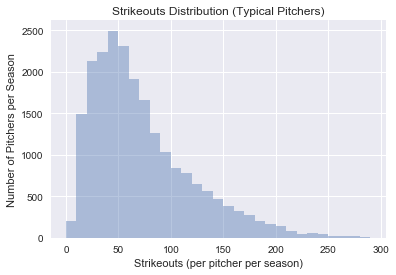

In [27]:
%matplotlib inline
# === Pitcher Single Dimensional Plots ===
# Earned Run Average
era_bins = np.arange(0,10,0.2)
sns.distplot(full_pitchers['ERA'], kde=False ,bins=era_bins)
plt.title("Earned Run Average Distribution (Typical Pitchers)")
plt.xlabel("Earned Run Average (per pitcher per season)")
plt.ylabel("Number of Pitchers per Season")
plt.show()

# Wins
wins_bins = np.arange(0,30,1)
sns.distplot(full_pitchers['W'], kde=False, bins=wins_bins)
plt.title("Wins Distribution (Typical Pitchers)")
plt.xlabel("Wins (per pitcher per season)")
plt.ylabel("Number of Pitchers per Season")
plt.show()

# Strikeouts
so_bins = np.arange(0,300,10)
sns.distplot(full_pitchers['SO'], kde=False, bins=so_bins)
plt.title("Strikeouts Distribution (Typical Pitchers)")
plt.xlabel("Strikeouts (per pitcher per season)")
plt.ylabel("Number of Pitchers per Season")
plt.show()

Pitchers Correlation ERA/W:  -0.31


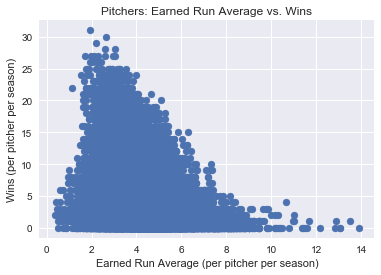



Pitchers Correlation ERA/SO:  -0.28


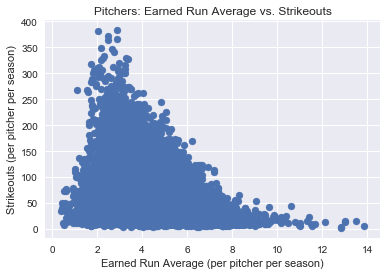



Pitchers Correlation SO/W:  0.78


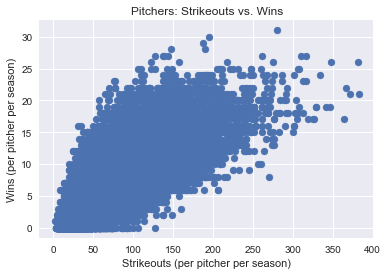

In [28]:
%matplotlib inline

# === Pitcher Two Dimensional Plots ===
# Earned Run Average vs. Wins
era_w_corr = correlate_columns(full_pitchers['ERA'], full_pitchers['W'])
print ("Pitchers Correlation ERA/W: ", "{:1.2f}".format(era_w_corr))

plt.scatter(full_pitchers['ERA'], full_pitchers['W'])
plt.title("Pitchers: Earned Run Average vs. Wins")
plt.xlabel("Earned Run Average (per pitcher per season)")
plt.ylabel("Wins (per pitcher per season)")
plt.show()
print("\n")

# Earned Run Average vs. Strikeouts
era_so_corr = correlate_columns(full_pitchers['ERA'], full_pitchers['SO'])
print ("Pitchers Correlation ERA/SO: ", "{:1.2f}".format(era_so_corr))

plt.scatter(full_pitchers['ERA'], full_pitchers['SO'])
plt.title("Pitchers: Earned Run Average vs. Strikeouts")
plt.xlabel("Earned Run Average (per pitcher per season)")
plt.ylabel("Strikeouts (per pitcher per season)")
plt.show()
print("\n")

# Strikeouts vs. Wins
so_w_corr = correlate_columns(full_pitchers['SO'], full_pitchers['W'])
print ("Pitchers Correlation SO/W: ", "{:1.2f}".format(so_w_corr))

plt.scatter(full_pitchers['SO'], full_pitchers['W'])
plt.title("Pitchers: Strikeouts vs. Wins")
plt.xlabel("Strikeouts (per pitcher per season)")
plt.ylabel("Wins (per pitcher per season)")
plt.show()

## Tentative Conculsions about Pitcher Statistics

Earned Run Average has a normal distribution among typical Major League Pitchers while Wins and Strikeouts are positively skewed.

"Earned Run Average" measures the number of "earned runs" a pitcher gives up per nine innings pitched.  "Earned runs" refer to runs that the offense scores without any help from the defensive team.  Generally, runs scored through hits and walks are earned while runs scored through errors are not.

If a pitcher gives up a single and a home run, there are two earned runs.  If the first batter reaches first base on a throwing error, then the second batter hits a home run, only one earned run is charged to the pitcher.

Earned Run Average is somewhat negatively correlated with number of Wins and Strikeouts.  A pitcher is less likely to win a game in which he gives up many earned runs.  However, any correlation is limited by the team's offensive capability.  A pitcher can give up six earned runs and get a victory if the team scores at least seven runs.  On the other hand, a pitcher loses when he gives up one earned run in a 1-0 loss.  Also, a manager may pull a pitcher early over a lousy performance but the team rallies and wins the game, resulting in a "no decision" for the pitcher.

For ERA/SO, a pitcher is less likely to accumulate a lot of strikeouts in a game in which he yields lots of earned runs.  A pitcher giving up no earned runs is is likely to pitch more innnigs and have more batters to strikeout.  This correlation is limited by factors including pitcher type.  Some pitchers power through and stikeout lots of hitters but others retire hitters through more ground ball outs.  The opposing team's batters provide a lot of variability which impacts the correlation of ERA/SO.

The largest positive correlation is SO/W.  A pitcher who strikes out a lot of batters is very likely giving up few hits and a few or no runs.  However, there are other factors including the team's offense and errors. A pitcher can strike out 15 batters in a 1-0 loss or can be pulled early with no strikeouts but his team wins 10-9!

One cannot say there is any causation between ERA and Wins or Strikeouts because there are many other factors, including the limitations of the ERA statistic itself.  Even the strongly correlated SO/W does not imply causation because of variable factors.

## All-Star Data Gathering

The mean, standard deviation, maximum, minimum, and correlations are complete for the typical baseball batter and pitcher from 1933 through 2016.  At this point, we will look at All-Star batters and pitchers, and compare those to the typical batter and pitcher.

In [29]:
# Get every All-Star player
full_allstars = pd.read_csv('AllstarFull.csv')

# Get the list of batters who made the All-Star game
allstar_batters = full_allstars.merge(full_batters,on=['yearID', 'playerID'],how='inner')

# Get the list of pitchers who made the All-Star game
allstar_pitchers = full_allstars.merge(full_pitchers,on=['yearID', 'playerID'], how='inner')

## All-Star Batter Statistics

Let's compare All-Star batters to typical batters and see how much better All-Stars perform in the Triple Crown metrics of Batting Average, Home Runs, and Runs Batted In.

In [30]:
from IPython.display import HTML, display

# Display table function
def display_table(data_frame_left, data_frame_right, title,
                  column_heading_left, column_heading_right,
                  df_column_name, format_string):
    '''
    Display table with two columns
    data_frame_left: Data frame used to display the left column
    data_frame_right: Data frame used to display the right column
    title: Heading above the table
    column_heading_left: Title of the left column
    column_heading_right: Title of the right column
    df_column_name: Column name to be compared; must be in both data frames
    format_string: How to format the data (e.g., "{:2.1f}")
    '''
    table_to_display = \
        [["", column_heading_left, column_heading_right],
        ["MEAN", format_string.format(data_frame_left[df_column_name].mean()), \
             format_string.format(data_frame_right[df_column_name].mean())],
        ["STD",  format_string.format(data_frame_left[df_column_name].std()), \
             format_string.format(data_frame_right[df_column_name].std())],
        ["MIN",  format_string.format(data_frame_left[df_column_name].min()), \
             format_string.format(data_frame_right[df_column_name].min())],
        ["MAX",  format_string.format(data_frame_left[df_column_name].max()), \
             format_string.format(data_frame_right[df_column_name].max())]]

    print(title)
    
    # This line comes from Stack Overflow
    # https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook
    display(HTML(
       '<table><tr>{}</tr></table>'.format(
           '</tr><tr>'.join(
               '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table_to_display)
           )
    ))
    
# Standarization
def get_standard_deviation(data_frame_left, data_frame_right, column_name):
    '''
    Get Standard Deviation of value of one column between two data frames
    '''
    return (data_frame_right[column_name].mean() - data_frame_left[column_name].mean()) \
            / data_frame_left[column_name].std(ddof=0)

# === Check out Triple Crown Statistics for All-Star Batters ===
print("Number of Batters:   ", len(full_batters))
print("Number of All-Stars: ", len(allstar_batters))
print("Percentage Selected: ", "{:2.1f}".format((len(allstar_batters) / len(full_batters)) * 100.0))
print("\n")

display_table(full_batters, allstar_batters, "Batting Average Comparison", "TYPICAL", "ALL-STAR", 'AVG', "{:1.3f}")
print("\n")

display_table(full_batters, allstar_batters, "Home Run Comparison", "TYPICAL", "ALL-STAR", 'HR', "{:2.1f}")
print("\n")

display_table(full_batters, allstar_batters, "Runs Batted In Comparison", "TYPICAL", "ALL-STAR", 'RBI', "{:3.1f}")
print("\n")

# Number of standard deviations from mean
print("Average All-Star batter is how many standard deviations from average batter?")
print("Batting Average: ", "{:1.3f}".format(get_standard_deviation(full_batters, allstar_batters, 'AVG')))
print("Home Runs:       ", "{:1.3f}".format(get_standard_deviation(full_batters, allstar_batters, 'HR')))
print("Runs Batted In:  ", "{:1.3f}".format(get_standard_deviation(full_batters, allstar_batters, 'RBI')))

Number of Batters:    23404
Number of All-Stars:  3467
Percentage Selected:  14.8


Batting Average Comparison


,TYPICAL,ALL-STAR
MEAN,0.264,0.292
STD,0.033,0.030
MIN,0.131,0.194
MAX,0.406,0.406




Home Run Comparison


,TYPICAL,ALL-STAR
MEAN,10.4,19.7
STD,9.5,12.5
MIN,0.0,0.0
MAX,73.0,73.0




Runs Batted In Comparison


,TYPICAL,ALL-STAR
MEAN,49.3,81.4
STD,27.8,27.8
MIN,2.0,7.0
MAX,183.0,183.0




Average All-Star batter is how many standard deviations from average batter?
Batting Average:  0.866
Home Runs:        0.982
Runs Batted In:   1.154


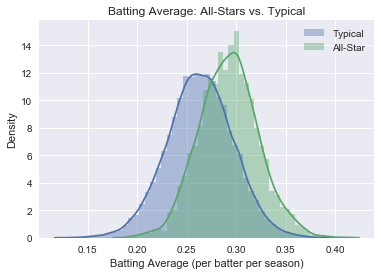

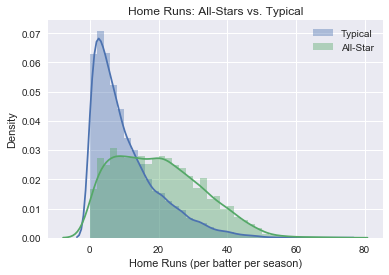

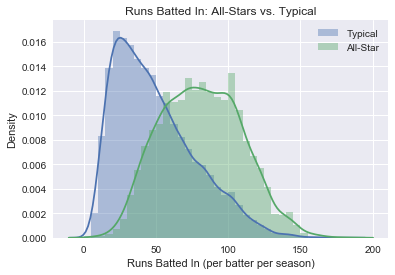

In [31]:
%matplotlib inline

# Constants
legend_list = ["Typical", "All-Star"]
ylabel = "Density"

# === Plot Triple Crown Statistics for All-Star Batters ===
# NOTE: "Density" shows the relationship between All-Stars and typical players better than raw number of players
# Batting Average plots
sns.distplot(full_batters['AVG'])
sns.distplot(allstar_batters['AVG'])
plt.title("Batting Average: All-Stars vs. Typical")
plt.xlabel("Batting Average (per batter per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Home Run plots
hr_bins = np.arange(0,70,2)
sns.distplot(full_batters['HR'], bins=hr_bins)
sns.distplot(allstar_batters['HR'], bins=hr_bins)
plt.title("Home Runs: All-Stars vs. Typical")
plt.xlabel("Home Runs (per batter per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Runs Batted In plots
rbi_bins = np.arange(0,160,5)
sns.distplot(full_batters['RBI'], bins=rbi_bins)
sns.distplot(allstar_batters['RBI'], bins=rbi_bins)
plt.title("Runs Batted In: All-Stars vs. Typical")
plt.xlabel("Runs Batted In (per batter per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

## Tentative Conculsions about All-Star Batters

An average All-Star batter will perform about one standard deviation better than a typical major league batter in the Triple Crown metrics of Batting Average, Home Runs, and Runs Batted In over the course of a full season.  These three factors have at least some positive correlation so one expects to see All-Stars with higher numbers in all three statistics.  However, there will be a lot of variation.

An All-Star player who gets injured during or shortly after the All-Star game may not achieve his typical statistics at season's end, especially for Home Runs and Runs Batted In, due to lack of plate appearances.  Extreme cases include players who were honored with All Star slots despite early season retirement (such as Lou Gehrig in 1939 and Mike Schmidt in 1989).  Also, a player who performs very well only in the second half of a season will not make the All-Star game but could have All-Star type numbers at season's end.

There are also variations in the type of offense produced by All-Stars.  Power hitters such as Mark McGuire hit a then season record 70 home runs in 1998 and had 147 RBIs.  However, his .299 average is near the average for an All-Star.  Other batters may be All-Stars thanks to fielding statistics, such as Shortstop Ozzie Smith, nicknamed the "Wizard" for his amazing play at Shortstop for the San Diego Padres and St. Louis Cardinals (from 1978 to 1996).  His batting statistics were below the typical All-Star in all three categories.  Triple Crown contenders will be near the top in all three metrics, driving the factors back upwards.

A typical All-Star batter perform one standard deviation better in each of the three Triple Crown statistics but there are too many factors involved to say that better performance in these metrics causes a batter to be named an All-Star.

## All-Star Pitcher Statistics

Let's compare All-Star pitchers to typical pitchers and see how much better All-Stars perform in the Pitching Triple Crown metrics of Earned Run Average, Wins, and Strikeouts.

In [32]:
# === Check out Triple Crown Statistics for All-Star Pitchers ===
print("Number of Pitchers:  ", len(full_pitchers))
print("Number of All-Stars: ", len(allstar_pitchers))
print("Percentage Selected: ", "{:2.1f}".format((len(allstar_pitchers) / len(full_pitchers)) * 100.0))
print("\n")

display_table(full_pitchers, allstar_pitchers, "Earned Run Average Comparison", "TYPICAL", "ALL-STAR", 'ERA', "{:1.2f}")
print("\n")

display_table(full_pitchers, allstar_pitchers, "Wins Comparison", "TYPICAL", "ALL-STAR", 'W', "{:2.1f}")
print("\n")

display_table(full_pitchers, allstar_pitchers, "Strikeouts Comparison", "TYPICAL", "ALL-STAR", 'SO', "{:3.1f}")
print("\n")

# Number of standard deviations from mean
print("Average All-Star pitcher is how many standard deviations from average pitcher?")
print("Earned Run Average: ", "{:1.3f}".format(get_standard_deviation(full_pitchers, allstar_pitchers, 'ERA')))
print("Wins:               ", "{:1.3f}".format(get_standard_deviation(full_pitchers, allstar_pitchers, 'W')))
print("Strikeouts:         ", "{:1.3f}".format(get_standard_deviation(full_pitchers, allstar_pitchers, 'SO')))

Number of Pitchers:   21847
Number of All-Stars:  1673
Percentage Selected:  7.7


Earned Run Average Comparison


,TYPICAL,ALL-STAR
MEAN,4.06,2.99
STD,1.26,0.75
MIN,0.38,0.54
MAX,13.89,6.87




Wins Comparison


,TYPICAL,ALL-STAR
MEAN,6.6,13.7
STD,5.2,6.3
MIN,0.0,0.0
MAX,31.0,31.0




Strikeouts Comparison


,TYPICAL,ALL-STAR
MEAN,72.4,137.0
STD,48.7,62.4
MIN,2.0,21.0
MAX,383.0,383.0




Average All-Star pitcher is how many standard deviations from average pitcher?
Earned Run Average:  -0.852
Wins:                1.370
Strikeouts:          1.327


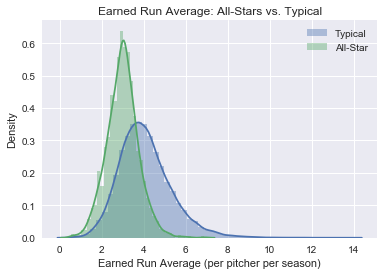

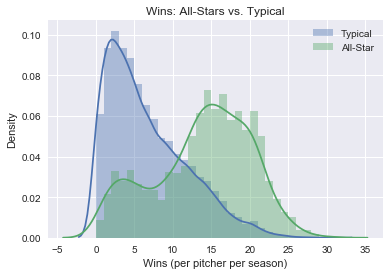

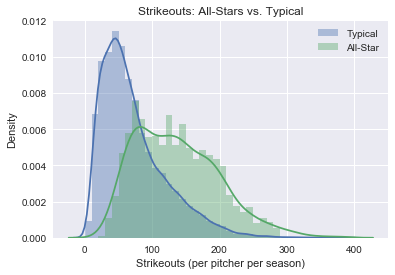

In [33]:
%matplotlib inline

# === Plot Triple Crown Statistics for All-Star Pitchers ===
# NOTE: "Density" shows the relationship between All-Stars and typical players better than raw number of players
# Earned Run Average plots
sns.distplot(full_pitchers['ERA'])
sns.distplot(allstar_pitchers['ERA'])
plt.title("Earned Run Average: All-Stars vs. Typical")
plt.xlabel("Earned Run Average (per pitcher per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Wins plots
wins_bins = np.arange(0,30,1)
sns.distplot(full_pitchers['W'], bins=wins_bins)
sns.distplot(allstar_pitchers['W'], bins=wins_bins)
plt.title("Wins: All-Stars vs. Typical")
plt.xlabel("Wins (per pitcher per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Strikeouts plots
so_bins = np.arange(0,300,10)
sns.distplot(full_pitchers['SO'], bins=so_bins)
sns.distplot(allstar_pitchers['SO'], bins=so_bins)
plt.title("Strikeouts: All-Stars vs. Typical")
plt.xlabel("Strikeouts (per pitcher per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

## Tentative Conculsions about All-Star Pitchers

An average All-Star pitcher has an Earned Run Average less than one standard deviation *below* the average pitcher.  The wins and strikeouts are more than one standard deviation above the average pitcher.  Earned Run Average is negatively correlated with Wins and Strikeouts so one expects to see the Earned Run Average lower than typical for an All-Star.  Again, there is a lot of variation, thanks to the limitations of the Earned Run Average statisitic.

An All-Star pitcher may play for a bad offensive team and therefore may have a very low ERA but few victories.  This pitcher may also have a high number of strikeouts.  An All-Star pitcher may play on a playoff team and have lots of victories despite an average or even high ERA.  An All-Star pitcher may have a low ERA but fewer victories thanks to errors made by a bad fielding team so that all the runs given up are not counted against the pitcher.  Also, we are comparing All-Stars and full season performance so injuries in the second half of a season also factor in driving down the Wins and Strikeouts at season's end.  "Second half" comebacks also are a factor.

A typical All-Star pitcher performs nearly one standard deviation better (lower) in ERA and more than one standard deviation better (higher) for Wins and Strikeouts.  However, better performance in these metrics does not "cause" a pitcher to be named an All-Star, thanks to variations.

## Triple Crown Winners Data Gathering

We have seen how well All-Star players perform in the Triple Crown metrics compared to the typical player.  Now we will focus on the rare triple crown winners and see how much better they perform.  Only Triple Crown winners since 1933 (the first All-Star year) are compared.

In [34]:
# Get every Triple Crown Winner in the All-Star era
alltime_award_winners = pd.read_csv('AwardsPlayers.csv')
full_award_winners = get_data_subset(alltime_award_winners, 'yearID', operator.ge, FIRST_ALL_STAR_YEAR)

full_batting_triple_crown_winners = \
    full_award_winners.groupby(full_award_winners['awardID'] == "Triple Crown").get_group(1)
full_pitching_triple_crown_winners = \
    full_award_winners.groupby(full_award_winners['awardID'] == "Pitching Triple Crown").get_group(1)

# Get the statistics of batters who won the Triple Crown
batting_triple_crown_winners = \
    full_batting_triple_crown_winners.merge(full_batters,on=['yearID', 'playerID'],how='inner')
print("Batting Triple Crown Winners: ", len(batting_triple_crown_winners))
print("\n")

# Get the statistics of pitchers who won the Pitching Triple Crown
pitching_triple_crown_winners = \
    full_pitching_triple_crown_winners.merge(full_pitchers,on=['yearID', 'playerID'], how='inner')
print("Pitching Triple Crown Winners: ", len(pitching_triple_crown_winners))
print("\n")

Batting Triple Crown Winners:  10


Pitching Triple Crown Winners:  18




## Triple Crown Batter Statistics

Let's compare Triple Crown batters to typical batters and see how much better they perform compared to average players in the metrics of Batting Average, Home Runs, and Runs Batted In.

In [35]:
# === Check out Triple Crown Statistics for All-Star Batters ===
display_table(full_batters, batting_triple_crown_winners, "Batting Average Comparison", \
              "TYPICAL", "TRIPLE CROWN", 'AVG', "{:1.3f}")
print("\n")

display_table(full_batters, batting_triple_crown_winners, "Home Run Comparison", \
              "TYPICAL", "TRIPLE CROWN", 'HR', "{:2.1f}")
print("\n")

display_table(full_batters, batting_triple_crown_winners, "Runs Batted In Comparison", \
              "TYPICAL", "TRIPLE CROWN", 'RBI', "{:3.1f}")
print("\n")

# Number of standard deviations from mean
print("Average Triple Crown batter is how many standard deviations from average batter?")
print("Batting Average: ", "{:1.3f}".format(get_standard_deviation(full_batters, batting_triple_crown_winners, 'AVG')))
print("Home Runs:       ", "{:1.3f}".format(get_standard_deviation(full_batters, batting_triple_crown_winners, 'HR')))
print("Runs Batted In:  ", "{:1.3f}".format(get_standard_deviation(full_batters, batting_triple_crown_winners, 'RBI')))

Batting Average Comparison


,TYPICAL,TRIPLE CROWN
MEAN,0.264,0.348
STD,0.033,0.019
MIN,0.131,0.316
MAX,0.406,0.374




Home Run Comparison


,TYPICAL,TRIPLE CROWN
MEAN,10.4,41.3
STD,9.5,8.8
MIN,0.0,28.0
MAX,73.0,52.0




Runs Batted In Comparison


,TYPICAL,TRIPLE CROWN
MEAN,49.3,136.5
STD,27.8,18.6
MIN,2.0,114.0
MAX,183.0,165.0




Average Triple Crown batter is how many standard deviations from average batter?
Batting Average:  2.556
Home Runs:        3.256
Runs Batted In:   3.135


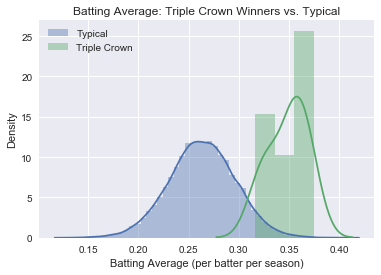

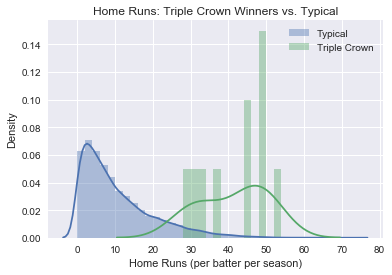

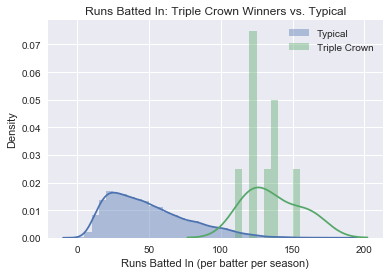

In [36]:
%matplotlib inline

# Constants
legend_list = ["Typical", "Triple Crown"]
ylabel = "Density"

# === Plot Triple Crown Statistics for Triple Crown Winners ===
# NOTE: "Density" shows the relationship between Triple Crown Winners and typical players better than 
# raw number of players
# Batting Average plots
sns.distplot(full_batters['AVG'])
sns.distplot(batting_triple_crown_winners['AVG'])
plt.title("Batting Average: Triple Crown Winners vs. Typical")
plt.xlabel("Batting Average (per batter per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Home Run plots
hr_bins = np.arange(0,70,2)
sns.distplot(full_batters['HR'], bins=hr_bins)
sns.distplot(batting_triple_crown_winners['HR'], bins=hr_bins)
plt.title("Home Runs: Triple Crown Winners vs. Typical")
plt.xlabel("Home Runs (per batter per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Runs Batted In plots
rbi_bins = np.arange(0,160,5)
sns.distplot(full_batters['RBI'], bins=rbi_bins)
sns.distplot(batting_triple_crown_winners['RBI'], bins=rbi_bins)
plt.title("Runs Batted In: Triple Crown Winners vs. Typical")
plt.xlabel("Runs Batted In (per batter per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

## Tentative Conculsions about Triple Crown Winning Batters

Triple Crown Winners has a Batting Average more than over 2.5 standard deviations above the typical player, around the top 0.5% of players!  The Home Runs and Runs Batted In are both more than three stanadard deviations above the typical player, in the top 0.1%!  Performing that well will put a player in contention for the Triple Crown but it does not "cause" a Triple Crown to be awarded.  There have been only ten Triple Crown Winners per player per season since 1933 among over 23000 All-Star "player per seasons". 

## Triple Crown Pitcher Statistics

Let's compare Pitching Triple Crown winners to typical pitches and see how much better they perform compared to average pitchers in the metrics of Earned Run Average, Wins, and Strikeouts.

In [37]:
# === Check out Pitching Triple Crown Statistics for All-Star Pitchers ===
display_table(full_pitchers, pitching_triple_crown_winners, "Earned Run Average Comparison", \
              "TYPICAL", "TRIPLE CROWN", 'ERA', "{:1.3f}")
print("\n")

display_table(full_pitchers, pitching_triple_crown_winners, "Wins Comparison", \
              "TYPICAL", "TRIPLE CROWN", 'W', "{:2.1f}")
print("\n")

display_table(full_pitchers, pitching_triple_crown_winners, "Strikeouts Comparison", \
              "TYPICAL", "TRIPLE CROWN", 'SO', "{:3.1f}")
print("\n")

# Number of standard deviations from mean
print("Average Triple Crown pitcher is how many standard deviations from average pitcher?")
print("Earned Run Average: ", "{:1.3f}".format(get_standard_deviation( \
                                full_pitchers, pitching_triple_crown_winners, 'ERA')))
print("Wins:               ", "{:1.3f}".format(get_standard_deviation( \
                                full_pitchers, pitching_triple_crown_winners, 'W')))
print("Strikeouts:         ", "{:1.3f}".format(get_standard_deviation( \
                                full_pitchers, pitching_triple_crown_winners, 'SO')))

Earned Run Average Comparison


,TYPICAL,TRIPLE CROWN
MEAN,4.058,2.199
STD,1.259,0.340
MIN,0.375,1.529
MAX,13.886,2.773




Wins Comparison


,TYPICAL,TRIPLE CROWN
MEAN,6.6,23.7
STD,5.2,2.8
MIN,0.0,19.0
MAX,31.0,27.0




Strikeouts Comparison


,TYPICAL,TRIPLE CROWN
MEAN,72.4,263.2
STD,48.7,61.9
MIN,2.0,137.0
MAX,383.0,382.0




Average Triple Crown pitcher is how many standard deviations from average pitcher?
Earned Run Average:  -1.476
Wins:                3.294
Strikeouts:          3.917


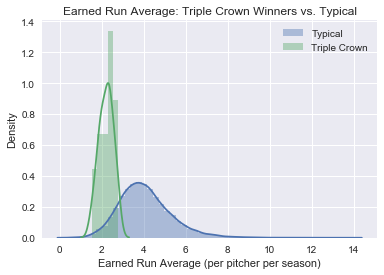

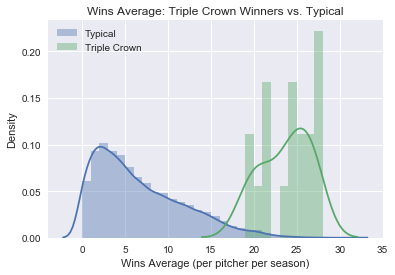

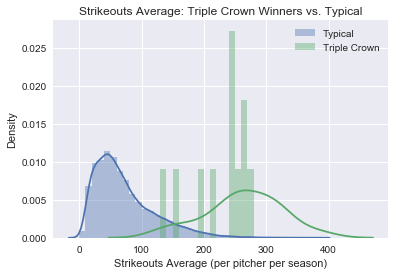

In [38]:
%matplotlib inline

# === Plot Pitching Triple Crown Statistics for Triple Crown Winners ===
# NOTE: "Density" shows the relationship between Triple Crown Winners and typical players better than 
# raw number of players
# Earned Run Average plots
sns.distplot(full_pitchers['ERA'])
sns.distplot(pitching_triple_crown_winners['ERA'])
plt.title("Earned Run Average: Triple Crown Winners vs. Typical")
plt.xlabel("Earned Run Average (per pitcher per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Wins plots
wins_bins = np.arange(0,30,1)
sns.distplot(full_pitchers['W'], bins=wins_bins)
sns.distplot(pitching_triple_crown_winners['W'], bins=wins_bins)
plt.title("Wins Average: Triple Crown Winners vs. Typical")
plt.xlabel("Wins Average (per pitcher per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

# Strikeouts plots
so_bins = np.arange(0,300,10)
sns.distplot(full_pitchers['SO'], bins=so_bins)
sns.distplot(pitching_triple_crown_winners['SO'], bins=so_bins)
plt.title("Strikeouts Average: Triple Crown Winners vs. Typical")
plt.xlabel("Strikeouts Average (per pitcher per season)")
plt.ylabel(ylabel)
plt.legend(legend_list)
plt.show()

## Tentative Conculsions about Triple Crown Winning Pitchers

Pitching Triple Crown Winners has a Earned Run Average a little less than 1.5 standard deviations below the typical pitcher, in the lowest 7% of pitchers.  The Wins are around 3.3 standard deviations above and Strikeouts are a stunning 3.9 standard deviations above the average pitcher.  The Wins are in the top 0.05% and the Strikeouts are in the top 0.01% of pitchers!

A low ERA does not guarantee that a pitcher can even contend for the Triple Crown.  A high number of strikeouts, however, gives a pitcher the best chance for contention.  A lot of strikeouts correlates strongly with number of wins, so a pitcher with lots of strikeouts has a higher chance of having lots of wins.  Even then, the Earned Run Average has too many variables so a high strikeout, high win pitcher still doesn't lead to Pitching Triple Crown contention on their own.

Performing very well in all three metrics will put a player in contention for the Triple Crown but it does not "cause" a Triple Crown to be awarded.  There have been only 18 Pitching Triple Crown Winners per player per season since 1933 among over 21000 All-Star pitcher "player per seasons".

## Summary

A typical All-Star batter performs about one standard deviation above an average player in the Triple Crown metrics of Batting Average, Home Runs, and Strikeouts - in the top 20% of each metric.  There is a lot of variation between batters so that a batter who performs outside the top 20% in these metrics is not necessarily denied an All-Star slot, nor is a player in the top 20% guaranteed a slot.

A typical All-Star pitcher performs less than one standard deviation better than average in their Earned Run Average metric so a lower ERA does not correlate well with an All-Star honor.  A typical All-Star pitcher is expected to have more Strikeouts and Wins, at least 1.3 standard deviations better, than an average pitcher.  Strikeouts and Wins are better predictors of an All-Star appearance than a lower ERA.  There are still too many variations to guarantee that more Wins and Strikeouts means an All-Star appearance for a pitcher.  The Strikeouts and Wins "predictor" is a tentative conclusion.

Triple Crown winners are much better than their average counterparts as one would expect - over three standard deviations better on Home Runs and Runs Batted In (for batters), and over three stanadrd deviations better in Wins and Strikeouts (for pitchers).  Performing this well leads to a higher chance of Triple Crown contention.  However, a great player must have a really special season to actually beat out equally talented players in three metrics to win a Triple Crown.

## Limitations and Further Exploration

This analysis suffers from the following limitations:

1. There is no data collected on seasons before the first All-Star game.

2. The Plate Appearances calculation does not include Sacrifice Fly balls before 1954 since the values are unknown.  The study assumes zero Sacrific Flies so some players could have been missed by the threshold for the 1933 to 1953 seasons.

3. The threshold was 162 Plate Appearances for batters and 16 games for pitchers.  How would different thresholds impact the measurements?

4. The study does not account for the impact that events in baseball history had on batting and pitching statistics, including but not limited to the following:

    1. Integration:  There are 14 full seasons in this study before Jackie Robinson's Major League Debut plus several more seasons where some teams did not have black players.

    2. Expansion: In the 1960s and 1970s, many more teams joined Major League Baseball, expanding the number of players and lowering the quality of play.

    3. Baseball lowered the pitching mound in 1969 to increase offensive statistics.

    4. Artificial turf increased a batter's ability to get runs batted in due to doubles and triples.

    5. Steroids usage in the 1990s and 2000s drove up home runs and runs batted in.  Mark McGuire shattered the then 37-year-old Home Run season record in 1998 and Barry Bonds broke that just three seasons later!

    6. The Colorado Rockies franchise started in 1993, resulting in an increase in Home Runs and Runs Batted In for Rockies players

Areas for Further Exploration:

1. Typical, All-Star, and Triple Crown player statistics could be broken up in time blocks to reflect changes (such as Pre-Integration, Expansion Era, Steroids Era, and more).  One can see if the different eras balance or skew the statistics for batters and pitchers.

2. Team quality can be explored (for example, Playoff Contenders versus others).

3. The Colorado Rockies could be tested separately to determine the impact of high elevation on the statistics!

4. Hypothesis testing can be run.  For example, different players could be tracked during their careers to see the impact of changes in their seasonal batting average on home runs and runs batted in.